# ¿Qué es y qué hace un web crawler?

Webcrawler: software (bot) que explora todo un sitio web para encontrar
e indexar las páginas que existen, esto puede ser mediante palabras clave
con expresiones regulares me imagino.

El chiste es hacer un indice de las páginas que tiene un sitio web
explorando por cada una mientras sea posible.

Tengo que recuperar las páginas y hacer un índice de las que existen
y son visibles en el sitio web.

## Un sitio web suele tener la siguiente estructura

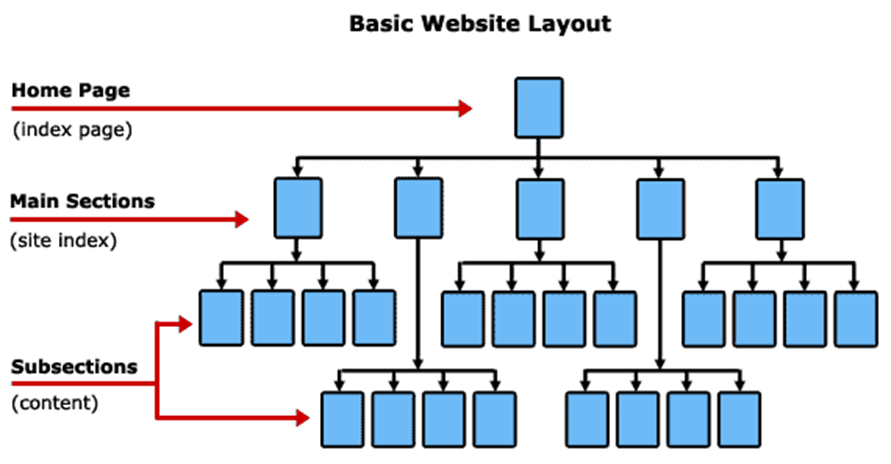

# ¿Cómo puedo explorar todas las páginas de un sitio web?

## Crear un árbol

Dada una página inicial que será la raíz del árbol:
* cada subárbol contendrá una lista de nodos hijos
* Se procesará cada nodo en la lista de manera recursiva
    - Por cada nodo en la lista se creará un nuevo subárbol que contendrá una lista donde meterá a los nuevos nodos encontrados


### Algoritmo (pseudocódigo)

~~~~
ALGORITMO Crawl(page, tree)
    
	Hacer scrape a page buscando links con expresiones regulares 
	Links  ← Recuperar todos los links en page

	Si longitud de Links = 0
		Retornar

	Para Cada link en Links hacer
		Nuevo node ← link
		Añade node a tree.children
		node.parent ← tree
	Para Cada node En tree.children Hacer
		Crawl(node.page, node)
~~~~

### Recorrer el árbol

Se hace un recorrido en profundidad si se quiere mostrar de dónde viene cada página y qué links tiene

# URLs que necesito encontrar

Aquellas que sean del propio sitio web, porque luego hay links de youtube o sitios muy grandes y va a valer madres mi compu

# Necesito...

## Python: requests, selenium
## Estructuras de datos: 
### Clase Node
* Tree parent
* List children
### Clase Tree
* Node root -> Raíz de todo el árbol

# Buscando titulos importantes
Para este caso, se buscarán los siguientes tag:
* `<h1>` de cada página, estos deben existir una unica vez en cada página
* `<h2>, <h3>` Porque en el gobierno no le saben y hay hasta info más importante en esos que en los h1
* `<meta name='keywords>` y cortar por espacios en blanco y comas
* `<meta property="og:description">`
* `<meta name='description'>`
* `<a class="enlaces_leido">` En DOF para posts utiles
* `id="divRubro"` para la SCJN

# Cómo buscar

He notado que hay sitios que tienen un sitemap, este podría yo armarlo haciendo webcrawling pero tardaría mucho. También vi que el DOF tiene un "sumario" donde enlistan los artículos y publicaciones en formato xml. La página de la Cámara de diputados no tiene ni mierdas así que en esa es de a fuerzas hacer webcrawling navegando entre los links de las páginas como lo he hecho desde un inicio.

Obviamente se respeta el /robots.txt, ya tengo un script para obtener las urls no permitidas

Entonces, podría buscar la información así:
1) Buscar un /sumario.xml y usarlo para encontrar las palabras clave y recuperar los links y sus encabezados
2) Buscar el /sitemap.xml y buscar las palabras clave si es que existe alguna etiqueta de descripción o algo
3) Hacer el webcrawling navegando al buscar links en cada página de manera recursiva como lo he estado haciendo
4) Es necesario a veces dejar un segundo o dos para esperar a que cargue y renderice la página completamente y aparezca todo el contenido

Este es el sumario que encontré después de haber hecho webcrawling en la página de DOF: https://www.dof.gob.mx/sumario.xml

## Problemas con el formato del texto del sumario.xml

Este es un item del sumario:
```
<item>
<title>PODER EJECUTIVO SECRETARIA DE GOBERNACION</title>
<link>
<![CDATA[ http://dof.gob.mx/nota_detalle.php?codigo=5726228&fecha=10/05/2024 ]]>
</link>
<description>
<![CDATA[ Convenio de Coordinaci&oacute;n y Adhesi&oacute;n que celebran la Secretar&iacute;a de Gobernaci&oacute;n, a trav&eacute;s de la Comisi&oacute;n Nacional para Prevenir y Erradicar la Violencia contra las Mujeres, el Estado de Zacatecas y la Secretar&iacute;a de las Mujeres, que tiene por objeto el otorgamiento de subsidio para el Proyecto denominado C-2024-030, referente al Programa de Apoyo para Refugios Especializados para Mujeres V&iacute;ctimas de Violencia de G&eacute;nero, sus Hijas e Hijos, para el ejercicio fiscal 2024. ]]>
</description>
<valueDate>10/05/2024</valueDate>
</item>
```

Al parecer no agarra las tíldes, por lo que la página los escribe con el siguiente patrón: & + *vocal sin tilde* + acute;

Para resolverlo podría usar el siguiente algoritmo:

In [ ]:
import requests
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ParseError
import html

def get_sumario(url):
    url_sumario = url.rstrip("/") + '/sumario.xml'
    response = requests.get(url_sumario, verify=False)

    try:
        if response.status_code == 200:
            # Parseando a XML
            tree = ET.ElementTree(ET.fromstring(response.content))
            root = tree.getroot()
            return root
    except ParseError:
        print('No es xml')

    return None

def scrape_sumario(sumario):
    items = sumario.findall('.//item')

    for item in items:
        title = item.find('.//title')
        description = item.find('.//description')
        link = item.find('.//link')

        print("\t", html.unescape(title.text))
        print(html.unescape(description.text))
        print(html.unescape(link.text))
        print("----------------------------")


sumario = get_sumario('https://www.dof.gob.mx/')
scrape_sumario(sumario)

	 PODER EJECUTIVO SECRETARIA DE GOBERNACION
Convenio de Coordinación y Adhesión que celebran la Secretaría de Gobernación, a través de la Comisión Nacional para Prevenir y Erradicar la Violencia contra las Mujeres, el Estado de Baja California Sur y el Instituto Municipal de la Mujer, que tiene por objeto el otorgamiento de subsidio para el Proyecto denominado R-2024-031, referente al Programa de Apoyo para Refugios Especializados para Mujeres Víctimas de Violencia de Género, sus Hijas e Hijos, para el ejercicio fiscal 2024.
http://dof.gob.mx/nota_detalle.php?codigo=5726225&fecha=10/05/2024
----------------------------
	 PODER EJECUTIVO SECRETARIA DE GOBERNACION
Convenio de Coordinación y Adhesión que celebran la Secretaría de Gobernación, a través de la Comisión Nacional para Prevenir y Erradicar la Violencia contra las Mujeres, el Estado de Jalisco y el Sistema Estatal para el Desarrollo Integral de la Familia, que tiene por objeto el otorgamiento de subsidio para el Proyecto denomin

C:\Python39\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dof.gob.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


# ¡Páginas para explorar!

* [Suprema Corte de Justicia de la Nación](https://www.scjn.gob.mx/)
* [Gaceta de la SCJN](https://egaceta.scjn.gob.mx/)
* [Diario Oficial de la Federación](https://www.dof.gob.mx/)

# Prototipos de código para encontrar links en una página

## Primer prototipo con BS4

Hay páginas que tienen links como
* https:\\/

* Se encuentran links en etiquetas `<a href="url"></a>`

* A veces no ponen toda la URL y sólo desde donde se encuentra la página, con una diagonal

* Hay que ignorar links que envien a alguna sección de la misma página porque se hará un bucle infinito, por ejemplo: https://pabloavelar.mx#about

In [ ]:
import re
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

"""
Obteniendo el dominio de una URI dada.
Debo de tener en cuenta que un nominio no es un .php, .html, .js, etc.

Recibe: string -> URI
Devuelve:
    string -> El dominio de la URI
    None -> Cuando no se encuentra el dominio
"""


def get_domain(uri):
    try:
        domain_pattern = r'(?:https?:\/\/)?(?:www\.)?([^\/]+\.(?!php|html)[a-z]+)'
        domain_match = re.search(domain_pattern, uri)
        if domain_match:
            return domain_match.group(1)
        else:
            return None
    except AttributeError as e:
        return None


def uri_cleaner(uri, domain, webpage):
    # Si es un php o html así puesto como si nada, puro nombre y extensión:
    pattern_only_filename = r'(\/?[a-z|A-Z|0-9|_|-]+(\.php|html))'
    only_filename_match = re.search(pattern_only_filename, uri)

    # Si es una página en la misma ruta base
    pattern_webpage = r'([a-z|A-Z|0-9|_|-]+(\.php|html)?$)'
    pattern_uri_filename = r'([a-z|A-Z|0-9|_|-]+(\/.+)?(\.php|html)?$)'  # (\.php|html)?$
    uri_filename_match = re.search(pattern_uri_filename, uri)
    webpage_match = re.search(pattern_webpage, webpage)

    if "#" in uri or 'javascript' in uri:
        return None

    if "#" in uri:
        return None

    uri_domain = get_domain(uri)

    if uri[0] == '/':
        uri = domain + uri
    elif uri_domain is None:  # or ".php" in uri_domain or ".html" in uri_domain

        if only_filename_match:
            uri = f'{domain}/{uri}'
        elif uri_filename_match and webpage_match.group(1) not in domain:
            uri = webpage.replace(webpage_match.group(1), uri_filename_match.group(1))

    elif uri_domain != domain:
        return None

    # Asignando el protocolo https para obtener un objeto correcto para el módulo requests
    if "http" not in uri and "https" not in uri:
        uri = "https://" + uri

        # Quitando el / del final
    if uri[len(uri) - 1] == '/':
        uri = uri[:-1]

    return uri


forms_action = []


def scraper():
    headers = {
        'User-Agent': UserAgent().chrome
    }

    website = "https://www.scjn.gob.mx/"

    # Si website tiene un / al final, se le quita
    website = website[:len(website) - 1] if website[len(website) - 1] == "/" else website
    #     website = "/comandos/bienvenido.php"

    # Para evitar que se descarguen archivos
    file_re = r'.*\.(docx|doc|pdf|xls|mp4|mp3|mkv|mpeg|png|jpeg|jpg|ico)$'
    file_match = re.search(file_re, website)

    if file_match:
        return None

    domain = get_domain(website)

    print("req: ", website)
    if domain is None:
        print("No se obtuvo el dominio. Retornando...")
        return
    #         raise Exception("No se pudo obtener dominio")
    r = None
    try:
        r = requests.get(website, headers=headers)
    except requests.exceptions.SSLError:
        # print("No se pudo verificar SSL")
        r = requests.get(website, headers=headers, verify=False)
    except:
        print("Error en la petición GET")

    soup = BeautifulSoup(r.content, 'lxml')
    links = []

    for link in soup.find_all('a', href=True):
        uri = link.get('href')
        # print(uri)
        if len(uri) == 0:
            continue

        uri = uri_cleaner(uri, domain, website)

        if uri is not None and uri not in links and uri != website:
            links.append(uri)

    print("\n".join(links))

if __name__ == '__main__':
    scraper()


req:  https://www.scjn.gob.mx
https://scjn.gob.mx
https://scjn.gob.mx/conoce-la-corte
https://scjn.gob.mx/pleno
https://scjn.gob.mx/presidencia
https://scjn.gob.mx/multimedia
https://scjn.gob.mx/transparencia
https://www.scjn.gob.mx/sites/default/files/boletin-mensual-resoluciones-pleno/2024-05/boletin-mensual-resoluciones-pleno-abril-2024.pdf
https://www.scjn.gob.mx/informate/sistema-de-citas-por-internet-scjn
https://scjn.gob.mx/transmision-en-vivo
https://scjn.gob.mx/constitucion-politica-de-los-estados-unidos-mexicanos
https://scjn.gob.mx/listas-de-notificaciones-de-pleno-primera-sala-y-segunda-sala
https://scjn.gob.mx/eventos-cursos
https://scjn.gob.mx/multimedia/versiones-taquigraficas
https://scjn.gob.mx/multimedia/boletin-mensual-resoluciones-del-pleno
https://www.scjn.gob.mx/transparencia/obligaciones-de-transparencia/procedimientos-contratacion-vigentes
https://www.scjn.gob.mx/sites/default/files/comunicacion_digital/2024-05/boletin_electronico_scjn_abril-2024.html
https://sc

## Segundo prototipo para encontrar la ruta absoluta de un link

In [ ]:
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import re

website = 'https://strikeout.im'
r = requests.get(website)

# Parseamos el HTML
soup = BeautifulSoup(r.content, 'lxml')
links = []
for link in soup.find_all('a', href=True):
    uri = link.get('href')       
    # Obtenemos la ruta absoluta
    ruta_absoluta = urljoin(website, uri)
    links.append(ruta_absoluta)

print("\n".join(links))

## Tercer prototipo utilizando Selenium
Esto es para que renderice JavaScript, esto suele ser necesario porque hay páginas creadas con React, Angular, entre otras tecnologías que utilizan puro javascript

### Librerías, funciones de get_domain y uri_cleaner

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import re
import time

"""
Obteniendo el dominio de una URI dada.
Debo de tener en cuenta que un nominio no es un .php, .html, .js, etc.

Recibe: string -> URI
Devuelve:
    string -> El dominio de la URI
    None -> Cuando no se encuentra el dominio
"""


def get_domain(uri):
    try:
        domain_pattern = r'(?:https?:\/\/)?(?:www[2]?\.)?([^\/]+\.(?!php|html)[a-z]+)'
        domain_match = re.search(domain_pattern, uri)
        if domain_match:
            return domain_match.group(1)
        else:
            return None
    except AttributeError as e:
        return None

print(get_domain('https://www2.scjn.gob.mx/ListaNotificacion/ListaNotificacionRotulon/320240507'))
print(get_domain('https://egaceta.scjn.gob.mx/detalle/tesis/2028505'))
print(get_domain('https://www2.scjn.gob.mx/ConsultaTematica/PaginasPub/TematicaPub.aspx'))

def uri_cleaner(uri, domain, webpage):
    # Si es un php o html así puesto como si nada, puro nombre y extensión:
    pattern_only_filename = r'(\/?[a-z|A-Z|0-9|_|-]+(\.php|html))'
    only_filename_match = re.search(pattern_only_filename, uri)

    # Si es una página en la misma ruta base
    pattern_webpage = r'([a-z|A-Z|0-9|_|-]+(\.php|html)?$)'
    pattern_uri_filename = r'([a-z|A-Z|0-9|_|-]+(\/.+)?(\.php|html)?$)'  # (\.php|html)?$
    uri_filename_match = re.search(pattern_uri_filename, uri)
    webpage_match = re.search(pattern_webpage, webpage)

    if "#" in uri or 'javascript' in uri or 'mailto' in uri:
        return None

    if "#" in uri:
        return None

    uri_domain = get_domain(uri)

    if uri[0] == '/':
        uri = domain + uri
    elif uri_domain is None:  # or ".php" in uri_domain or ".html" in uri_domain

        if only_filename_match:
            uri = f'{domain}/{uri}'
        elif uri_filename_match and webpage_match.group(1) not in domain:
            uri = webpage.replace(webpage_match.group(1), uri_filename_match.group(1))
        else:
            return None

    elif uri_domain != domain:
        return None

    # Asignando el protocolo https para obtener un objeto correcto para el módulo requests
    if "http" not in uri and "https" not in uri:
        uri = "https://" + uri

        # Quitando el / del final
    if uri[len(uri) - 1] == '/':
        uri = uri[:-1]

    return uri


forms_action = []

scjn.gob.mx
egaceta.scjn.gob.mx
scjn.gob.mx


### Función scraper

In [ ]:
def scraper(website):
    # Configurar las opciones de Chrome para ejecutar en modo headless
    chrome_options = Options()
    chrome_options.add_argument("--headless")

    # Inicializar el navegador Chrome en modo headless
    driver = webdriver.Chrome(options=chrome_options)
    
    # Si website tiene un / al final, se le quita
    website = website[:len(website) - 1] if website[len(website) - 1] == "/" else website
    #     website = "/comandos/bienvenido.php"

    # Para evitar que se descarguen archivos
    file_re = r'.*\.(docx|doc|pdf|xls|mp4|mp3|mkv|mpeg|png|jpeg|jpg|ico)$'
    file_match = re.search(file_re, website)

    if file_match:
        return None

    domain = get_domain(website)

    print("req: ", website)
    if domain is None:
        print("No se obtuvo el dominio. Retornando...")
        return
    #         raise Exception("No se pudo obtener dominio")
    driver.get(website)
    time.sleep(2)
    links = []
    headers = []
    
    for link in driver.find_elements(By.TAG_NAME, 'a'):
        uri = link.get_attribute('href')
        if uri is None or uri == '':
            continue

        # print(uri)
        uri = uri_cleaner(uri, domain, website)

        if uri is not None and uri not in links and uri != website:
            links.append(uri)
    print("paginas")    
    print("\n".join(links))
    print("fin")


if __name__ == '__main__':
    scraper('https://egaceta.scjn.gob.mx/busqueda-global-tesis')


req:  https://egaceta.scjn.gob.mx/busqueda-global-tesis
paginas
https://egaceta.scjn.gob.mx
https://egaceta.scjn.gob.mx/busqueda-global-ejecutorias
https://egaceta.scjn.gob.mx/busqueda-global-votos
https://egaceta.scjn.gob.mx/busqueda-global-acuerdos
https://egaceta.scjn.gob.mx/busqueda-global-otros
https://egaceta.scjn.gob.mx/busqueda-global-otros-tribunales
https://egaceta.scjn.gob.mx/gaceta-pdf
https://egaceta.scjn.gob.mx/busqueda-tematica
https://egaceta.scjn.gob.mx/organo-emisor
https://egaceta.scjn.gob.mx/detalle/tesis/2028507
https://egaceta.scjn.gob.mx/detalle/tesis/2028506
https://egaceta.scjn.gob.mx/detalle/tesis/2028505
https://egaceta.scjn.gob.mx/detalle/tesis/2028504
https://egaceta.scjn.gob.mx/detalle/tesis/2028503
https://egaceta.scjn.gob.mx/detalle/tesis/2028502
https://egaceta.scjn.gob.mx/detalle/tesis/2028501
https://egaceta.scjn.gob.mx/detalle/tesis/2028500
https://egaceta.scjn.gob.mx/detalle/tesis/2028499
https://egaceta.scjn.gob.mx/detalle/tesis/2028498
fin


# Reglas de robots.txt
En esta parte se crea un algoritmo para leer el robots.txt y respetar las reglas del sitio web

Se obtienen las rutas no permitidas por el sitio web.

In [ ]:
import requests
import re

def get_disallowed(robots_txt) -> list:
    # Buscando el user agent *
    user_agents = robots_txt.split("User-agent: ")    
    disallow_re = re.compile(r"Disallow:\s*(.*)")
    
    my_user_agent = None
    for ua in user_agents:
        if len(ua) > 0 and ua[0] == '*':
            my_user_agent = ua
            break
            
    if my_user_agent is None:
        return []
    
    disallow_match = disallow_re.findall(my_user_agent)
    return disallow_match
    

def read_robots_txt(url):
    url_robots_txt = url.rstrip("/") + '/robots.txt'
    
    r = requests.get(url_robots_txt, verify=False)
    if r.status_code != 200:
        print("No se pudo recuperar robots.txt. Status code: " + str(r.status_code))
        return
    
    disallowed = get_disallowed(r.text)
    
    print("Not allowed:")
    print("\n".join(disallowed))

if __name__ == '__main__':
    read_robots_txt('https://www.scjn.gob.mx/')

Not allowed:
/core/
/profiles/
/README.txt
/web.config
/admin/
/comment/reply/
/filter/tips
/node/add/
/search/
/user/register/
/user/password/
/user/login/
/user/logout/
/index.php/admin/
/index.php/comment/reply/
/index.php/filter/tips
/index.php/node/add/
/index.php/search/
/index.php/user/password/
/index.php/user/register/
/index.php/user/login/
/index.php/user/logout/


C:\Python39\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.scjn.gob.mx'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


# Ejemplos de busquedas con informacion util para estudiantes
Ejemplos de informacion util a los estudiantes que podemos recopilar con el webcrawler vendria siendo informacion sobre las becas. En este apartado se listaran algunos ejemplos.

# Busqueda #1
En este caso usamos el link de 'https://becasbenitojuarez.net/' con las palabras clave de 'guadalajara,universidad,udg,cucei,monto,requisitos,promedio,pais,extranjero'

Resultados de la búsqueda:

Requisitos de la convocatoria Beca Jóvenes Escribiendo el Futuro 2023-2
https://www.becasbenitojuarez.net/convocatoria-beca-jovenes-escribiendo-el-futuro-2023-2
*--------



# Busqueda #2

En este caso usamos el link de 'https://becasbenitojuarez.net/reglas-de-operacion-del-programa-beca-para-el-bienestar-benito-juarez-de-educacion-superior-2024/' con las palabras clave de 'guadalajara,universidad,udg,cucei,monto,requisitos,promedio,pais,extranjero'
Resultados de la búsqueda:

¿Cuáles son los requisitos para solicitar una beca de nivel básico a través de este programa?
https://www.becasbenitojuarez.net/reglas-de-operacion-del-programa-de-becas-de-educacion-basica-para-el-bienestar-benito-juarez-2024
* --------
Características de la beca y monto
https://becasbenitojuarez.net/reglas-de-operacion-del-programa-beca-para-el-bienestar-benito-juarez-de-educacion-superior-2024
* --------
¿Cuáles son los requisitos para solicitar una beca de Nivel Superior a través de este programa?
https://becasbenitojuarez.net/reglas-de-operacion-del-programa-beca-para-el-bienestar-benito-juarez-de-educacion-superior-2024
* --------
¿Cuál es el monto de la beca que se puede otorga para los estudiantes beneficiarios?
https://www.becasbenitojuarez.net/reglas-de-operacion-del-programa-de-becas-de-educacion-basica-para-el-bienestar-benito-juarez-2024
* --------

# Busqueda #3 para becas de excelencia extranjeras
Características de la beca y monto
https://becasbenitojuarez.net/reglas-de-operacion-del-programa-beca-para-el-bienestar-benito-juarez-de-educacion-superior-2024
* --------
¿Cuáles son los requisitos para solicitar una beca de Nivel Superior a través de este programa?
https://becasbenitojuarez.net/reglas-de-operacion-del-programa-beca-para-el-bienestar-benito-juarez-de-educacion-superior-2024
¿Cuáles son los requisitos para solicitar una beca de nivel básico a través de este programa?
* --------
Requisitos de la convocatoria Beca Jóvenes Escribiendo el Futuro 2023-2
https://www.becasbenitojuarez.net/convocatoria-beca-jovenes-escribiendo-el-futuro-2023-2
* --------